In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


# code start here

In [2]:
df = pd.read_pickle('../KeplerAges/Kinages_Prot.pkl')

In [3]:
df.columns

Index(['KIC_x', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2',
       ...
       'all_vz_new', 'v_t', 'v_b', 'kin_age_err', 'nostars', 'teff_calc',
       'vz_err', 'vz_err_all', 'Prot_new', 'kin_age_err_AVR'],
      dtype='object', length=258)

In [4]:
df['τc'] = calc_tc(df['teff_calc'])
df['Ro'] = df['Prot']/df['τc']

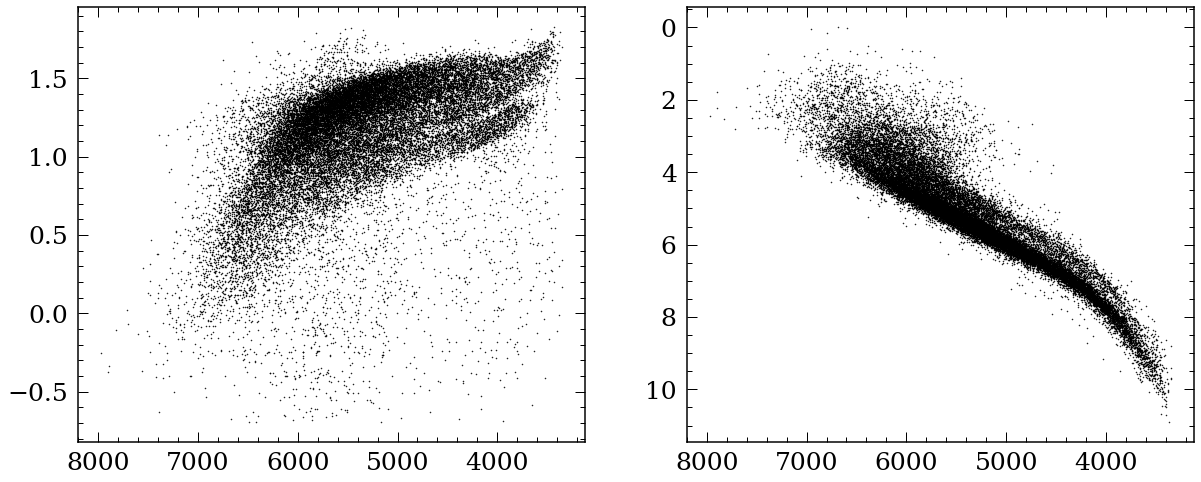

In [5]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['teff_calc'], np.log10(df['Prot']), 'k.', markersize=1)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plt.plot(df['teff_calc'], df['abs_G'], 'k.', markersize=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Cut binaries

27687


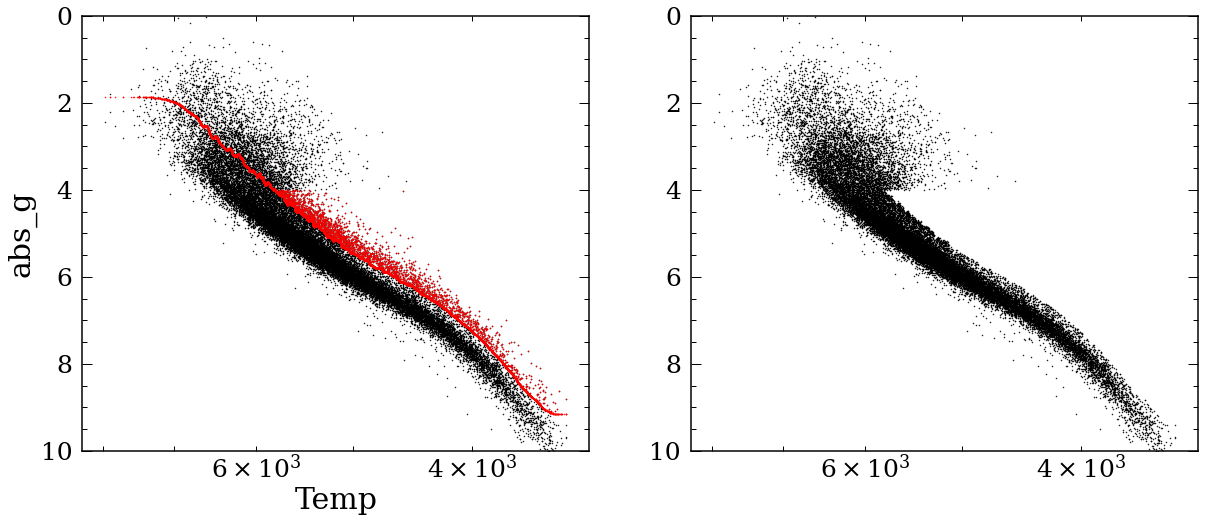

In [6]:
plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.semilogx(df['teff_calc'],df['abs_G'],'k.',markersize=1)
df = df.sort_values(by='teff_calc').reset_index(drop=True)
absgsmooth = gaussian_filter(df['abs_G'].values, 100)

plt.semilogx(df['teff_calc'],absgsmooth-0.4,'r.',markersize=1)

m=df['abs_G']<absgsmooth-0.4
m=m&(df['abs_G']>4)

plt.semilogx(df['teff_calc'][m],df['abs_G'][m],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

plt.subplot(1,2,2)
df_nob = df[~m].reset_index(drop=True)
plt.semilogx(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(len(df_nob))

# optimize to AS and cluster ages

## AS ages

In [7]:
ASstars = pd.read_csv('ASage.csv')  

ASKICs = ASstars['KIC'].unique()
ASage = np.zeros(len(ASKICs))
ASage_err = np.zeros(len(ASKICs))
for i in range(len(ASKICs)):
    singstar = ASstars.loc[ASstars['KIC']==ASKICs[i]]
    ASage_err[i] = max(singstar['Age'])-min(singstar['Age'])
    ASage[i] = np.mean(singstar['Age'])
ASages = pd.DataFrame(np.array((ASKICs, ASage, ASage_err)).T, columns=['KIC','Age','Age_err'])
ASages = pd.merge(ASages, df_nob, left_on='KIC', right_on='KID', how='inner')
ASages = ASages.loc[ASages['Ro']<2].reset_index(drop=True)


## Add in cluster ages

In [8]:
from astropy.io import ascii
clusters = (ascii.read('ocage')).to_pandas()

In [9]:
clusterkids = range(len(clusters))
clusterteffs = clusters['Teff'].values
clusterprotlog = np.log10(clusters['Prot'].values)
clusterabsg = clusters['MGmag'].values
clusterro = clusters['Prot'].values/calc_tc(clusterteffs)
clusterprot = clusters['Prot'].values
clustervz = np.zeros(len(clusters))
clusterage = clusters['Age'].values
clusterage_err = clusters['Age'].values*0.05
clusterdf = pd.DataFrame(np.array((clusterkids,clusterteffs,clusterprotlog,clusterabsg,clusterro,clustervz,clusterage,clusterage_err,clusterprot)).T,
                        columns=['KID','teff_calc','Prot_log','abs_G','Ro','all_vz','Age','Age_err','Prot'])

clusterdf = clusterdf.loc[clusterdf['Ro']<2].reset_index(drop=True)
clusterdf = clusterdf.loc[clusterdf['teff_calc']<5000].reset_index(drop=True)
clusterdf = clusterdf.loc[clusterdf['Age']>1].reset_index(drop=True)
df_nob = pd.concat([df_nob, clusterdf])


In [10]:
"""uniquecluster = cluster.Cluster.unique()
clusterkids = range(len(uniquecluster))
clusterteffs, clusterprotlog, clusterabsg, clusterro, clustervz = np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster))
for i in range(len(uniquecluster)):
    sing_clust = cluster.loc[cluster['Cluster']==uniquecluster[i]]
    clusterteffs[i] = np.median(sing_clust['Teff'].values)
    clusterprotlog[i] = np.median(np.log10(cluster['Prot'].values))
    clusterabsg[i] = np.median(cluster['MGmag'].values)
    clusterro[i] = np.median(cluster['Prot'].values/calc_tc(clusterteffs))
    
clusterdf = pd.DataFrame(np.array((clusterkids,clusterteffs,clusterprotlog,clusterabsg,clusterro,clustervz)).T,
                        columns=['KID','teff_calc','Prot_log','abs_G','Ro','all_vz'])

df_nob = pd.concat([df_nob, clusterdf])

"""

"uniquecluster = cluster.Cluster.unique()\nclusterkids = range(len(uniquecluster))\nclusterteffs, clusterprotlog, clusterabsg, clusterro, clustervz = np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster)), np.zeros(len(uniquecluster))\nfor i in range(len(uniquecluster)):\n    sing_clust = cluster.loc[cluster['Cluster']==uniquecluster[i]]\n    clusterteffs[i] = np.median(sing_clust['Teff'].values)\n    clusterprotlog[i] = np.median(np.log10(cluster['Prot'].values))\n    clusterabsg[i] = np.median(cluster['MGmag'].values)\n    clusterro[i] = np.median(cluster['Prot'].values/calc_tc(clusterteffs))\n    \nclusterdf = pd.DataFrame(np.array((clusterkids,clusterteffs,clusterprotlog,clusterabsg,clusterro,clustervz)).T,\n                        columns=['KID','teff_calc','Prot_log','abs_G','Ro','all_vz'])\n\ndf_nob = pd.concat([df_nob, clusterdf])\n\n"

In [11]:
clusterAS = pd.concat([ASages, clusterdf])

# Rotate 

In [12]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [13]:
df_nob = df_nob[[i for i in df_nob.columns if 'Age' not in i]]

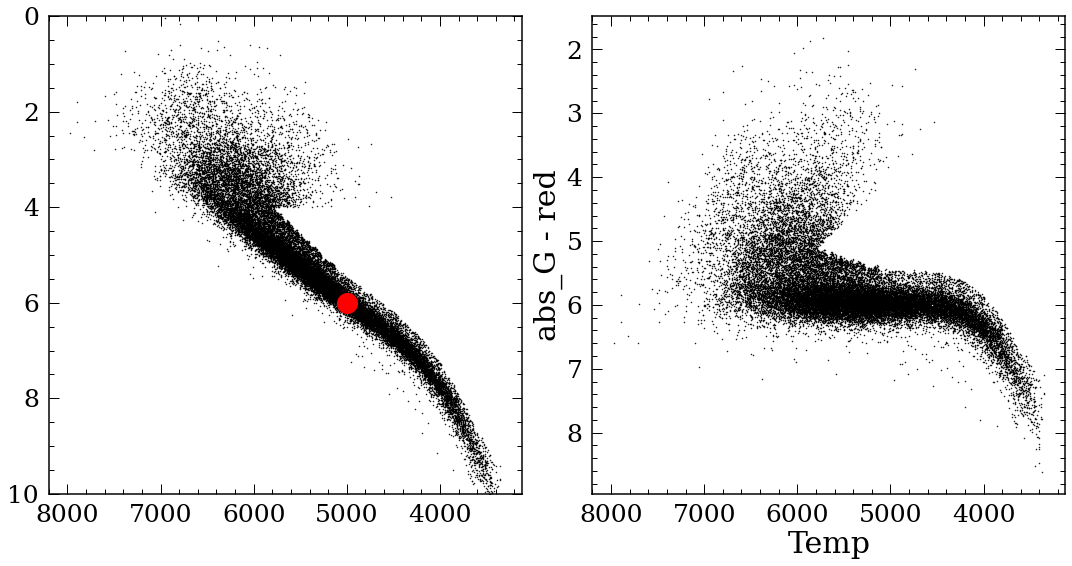

In [14]:
from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation as R

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G'],'ro')

plt.plot([5e3],[6],'ro',markersize=20)

df_nob = df_nob.sort_values(by='teff_calc').reset_index(drop=True)

"""
r = R.from_euler('xyz',(80,80,0), degrees=True) 
p_r=r.apply(np.array([df_nob['teff_calc'].values,df_nob['abs_G'].values,
                      np.zeros(len(df_nob))]).T) #Rotated points
"""

x,y = rotate([5e3,6],[df_nob['teff_calc'].values,df_nob['abs_G'].values],0.0014)

plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(x,y,'k.',markersize=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

df_nob['abs_G_rot'] = y
df_nob['teff_rot'] = x

plt.xlabel('Temp')
plt.ylabel('abs_G - red')
plt.tight_layout()

In [15]:
clusterAS = pd.merge(clusterAS[['KID','Age','Age_err']], df_nob, left_on='KID',
                    right_on='KID',how='inner')


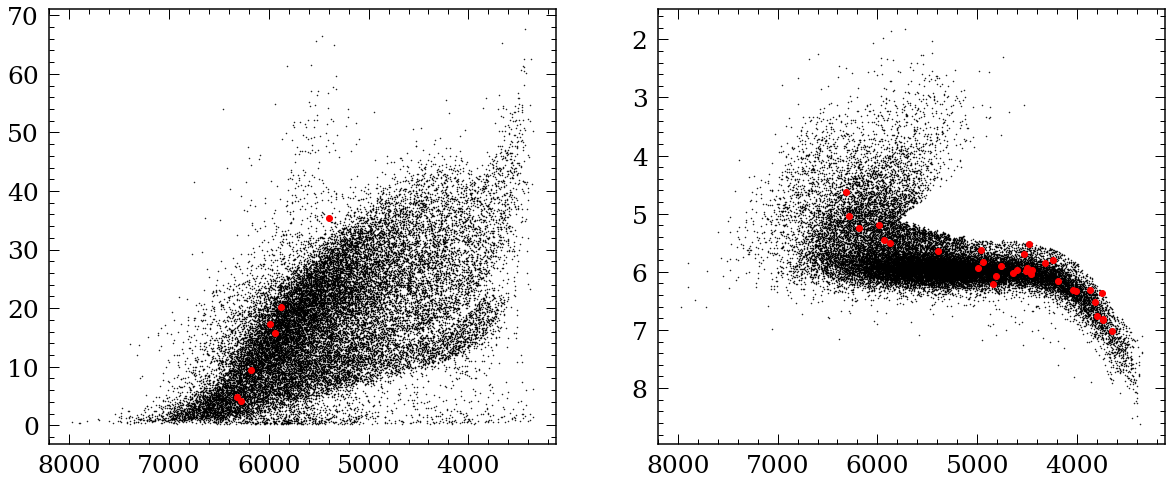

In [16]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'], df_nob['Prot'], 'k.', markersize=1)
plt.plot(ASages['teff_calc'], ASages['Prot'], 'ro')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.plot(df_nob['teff_calc'], df_nob['abs_G_rot'], 'k.', markersize=1)
plt.plot(clusterAS['teff_calc'], clusterAS['abs_G_rot'], 'ro')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


In [17]:

df_nob = df_nob.dropna(subset=['teff_calc','Prot_log','abs_G_rot','Ro']).reset_index(drop=True)

opt_binsize, df_common, chisq = optimizeBins(df_nob,ASages,['teff_calc','abs_G_rot','Ro','Prot_log'],
                                             [200,0.1,0.1,0.1],[300,0.2,0.2,0.5],
                                             min_star=15,max_star=50000,df_match_name='Age',
                                             df_match_name_err='Age_err',vz='all_vz',
                                             bintestNo=10,errVals=False)

df_common = pd.merge(df_common, df_nob[['KID','Ro']], 
                     left_on='KID', right_on='KID', how='inner')
opt_binsize, chisq

100%|██████████| 7/7 [00:00<00:00, 998.13it/s]


([288.8888888888889,
  0.12222222222222223,
  0.14444444444444446,
  0.23333333333333334],
 0.10342648639250782)

Text(0, 0.5, 'Gyro-kinematic Age [Gyr]')

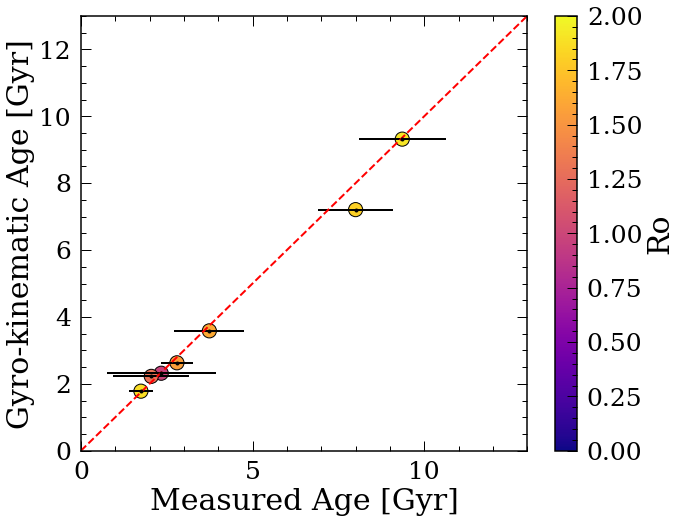

In [18]:


plt.figure(figsize=(10,8))
plt.errorbar(df_common['measure_age'],df_common['kin_age'],
             xerr=df_common['measure_age_err'],
             fmt='k.')

plt.scatter(df_common['measure_age'],df_common['kin_age'],
             c=df_common['Ro'],s=200,edgecolor='k',vmin=0,vmax=2,
           cmap='plasma')
cb = plt.colorbar()
cb.set_label('Ro')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')



# calculate all stars

In [19]:
df_nob['vel_dis'],df_nob['kin_age']=getkinAges(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                                               opt_binsize,vz='all_vz',min_star=15,max_star=50000)



100%|██████████| 27714/27714 [00:12<00:00, 2285.81it/s]

10336



<ipython-input-1-810b26a1c2c9>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [20]:
ages = getkinAges_err(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                   ['teff_err1','abs_G_err','Ro_err','Prot_err'],
                   opt_binsize,min_star=10,sampsize=50,
                   vz='all_vz',vz_err='vz_err_all')


<ipython-input-1-810b26a1c2c9>:218: RuntimeWarning: invalid value encountered in log10
  newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))


0.0


  0%|          | 0/27714 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 27714/27714 [00:16<00:00, 1631.71it/s]
<ipython-input-1-810b26a1c2c9>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))


21753
0.02


100%|██████████| 27714/27714 [00:17<00:00, 1623.73it/s]


21630
0.04


100%|██████████| 27714/27714 [00:17<00:00, 1595.59it/s]


21923
0.06


100%|██████████| 27714/27714 [00:17<00:00, 1590.06it/s]


21809
0.08


100%|██████████| 27714/27714 [00:17<00:00, 1612.83it/s]


21732
0.1


100%|██████████| 27714/27714 [00:16<00:00, 1632.01it/s]


21798
0.12


100%|██████████| 27714/27714 [00:16<00:00, 1641.28it/s]


21713
0.14


100%|██████████| 27714/27714 [00:16<00:00, 1649.31it/s]


21708
0.16


100%|██████████| 27714/27714 [00:16<00:00, 1637.67it/s]


21592
0.18


100%|██████████| 27714/27714 [00:16<00:00, 1638.79it/s]


21618
0.2


100%|██████████| 27714/27714 [00:17<00:00, 1614.78it/s]


21882
0.22


100%|██████████| 27714/27714 [00:16<00:00, 1630.38it/s]


21787
0.24


100%|██████████| 27714/27714 [00:17<00:00, 1605.41it/s]


21713
0.26


100%|██████████| 27714/27714 [00:16<00:00, 1641.23it/s]


21596
0.28


100%|██████████| 27714/27714 [00:16<00:00, 1634.88it/s]


21683
0.3


100%|██████████| 27714/27714 [00:17<00:00, 1628.28it/s]


21647
0.32


100%|██████████| 27714/27714 [00:16<00:00, 1637.45it/s]


21707
0.34


100%|██████████| 27714/27714 [00:17<00:00, 1624.64it/s]


21719
0.36


100%|██████████| 27714/27714 [00:16<00:00, 1637.31it/s]


21748
0.38


100%|██████████| 27714/27714 [00:17<00:00, 1627.65it/s]


21634
0.4


100%|██████████| 27714/27714 [00:17<00:00, 1612.53it/s]


21741
0.42


100%|██████████| 27714/27714 [00:18<00:00, 1537.13it/s]


21628
0.44


100%|██████████| 27714/27714 [00:16<00:00, 1632.78it/s]


21626
0.46


100%|██████████| 27714/27714 [00:16<00:00, 1641.05it/s]


21534
0.48


100%|██████████| 27714/27714 [00:17<00:00, 1586.75it/s]


21670
0.5


100%|██████████| 27714/27714 [00:16<00:00, 1642.00it/s]


21642
0.52


100%|██████████| 27714/27714 [00:16<00:00, 1648.62it/s]


21666
0.54


100%|██████████| 27714/27714 [00:16<00:00, 1638.11it/s]


21805
0.56


100%|██████████| 27714/27714 [00:16<00:00, 1640.62it/s]


21631
0.58


100%|██████████| 27714/27714 [00:17<00:00, 1622.67it/s]


21752
0.6


100%|██████████| 27714/27714 [00:16<00:00, 1640.87it/s]


21696
0.62


100%|██████████| 27714/27714 [00:16<00:00, 1636.61it/s]


21727
0.64


100%|██████████| 27714/27714 [00:17<00:00, 1624.62it/s]


21712
0.66


100%|██████████| 27714/27714 [00:16<00:00, 1650.38it/s]


21649
0.68


100%|██████████| 27714/27714 [00:16<00:00, 1635.26it/s]


21745
0.7


100%|██████████| 27714/27714 [00:16<00:00, 1656.47it/s]


21584
0.72


100%|██████████| 27714/27714 [00:16<00:00, 1656.17it/s]


21675
0.74


100%|██████████| 27714/27714 [00:16<00:00, 1634.40it/s]


21651
0.76


100%|██████████| 27714/27714 [00:16<00:00, 1650.79it/s]


21750
0.78


100%|██████████| 27714/27714 [00:17<00:00, 1602.62it/s]


21770
0.8


100%|██████████| 27714/27714 [00:17<00:00, 1627.23it/s]


21776
0.82


100%|██████████| 27714/27714 [00:17<00:00, 1613.94it/s]


21669
0.84


100%|██████████| 27714/27714 [00:17<00:00, 1622.02it/s]


21712
0.86


100%|██████████| 27714/27714 [00:17<00:00, 1618.29it/s]


21609
0.88


100%|██████████| 27714/27714 [00:16<00:00, 1643.65it/s]


21712
0.9


100%|██████████| 27714/27714 [00:16<00:00, 1651.80it/s]


21548
0.92


100%|██████████| 27714/27714 [00:16<00:00, 1636.90it/s]


21709
0.94


100%|██████████| 27714/27714 [00:16<00:00, 1645.60it/s]


21612
0.96


100%|██████████| 27714/27714 [00:16<00:00, 1645.90it/s]


21841
0.98


100%|██████████| 27714/27714 [00:16<00:00, 1643.69it/s]

21648


In [21]:
new_age, ageerr = np.zeros(len(df_nob)), np.zeros(len(df_nob))
for i in trange(len(df_nob)):
    new_age[i] = np.median(ages[i,:])
    ageerr[i] = np.std(ages[i,:])
    

100%|██████████| 27714/27714 [00:00<00:00, 28307.85it/s]


In [22]:
df_nob['kin_age_ave'] = new_age
df_nob['kin_age_err'] = ageerr

Text(0, 0.5, 'M$_G$')

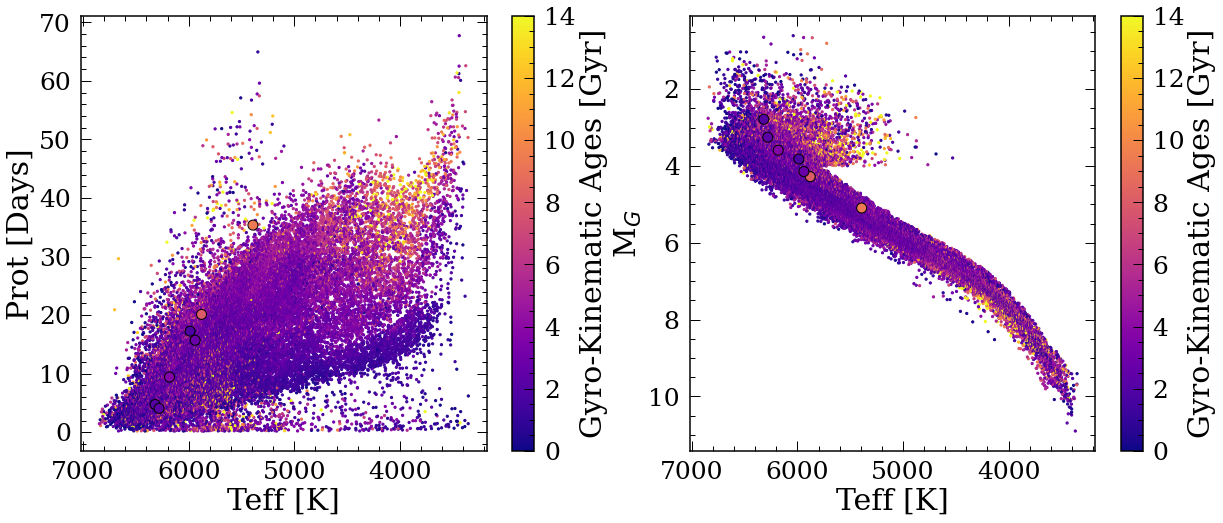

In [23]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=5,
            vmin=0,vmax=14,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['Prot'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=14,cmap='plasma')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(1,2,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G'], c=df_nob['kin_age'],s=5,
           vmin=0,vmax=14,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['abs_G'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=14,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')



# Compare to my old ages

In [24]:
oldage = pd.read_pickle('../KeplerAges/Kinages_Prot.pkl')

Text(0, 0.5, 'Old gyro-kinematic age [Gyr]')

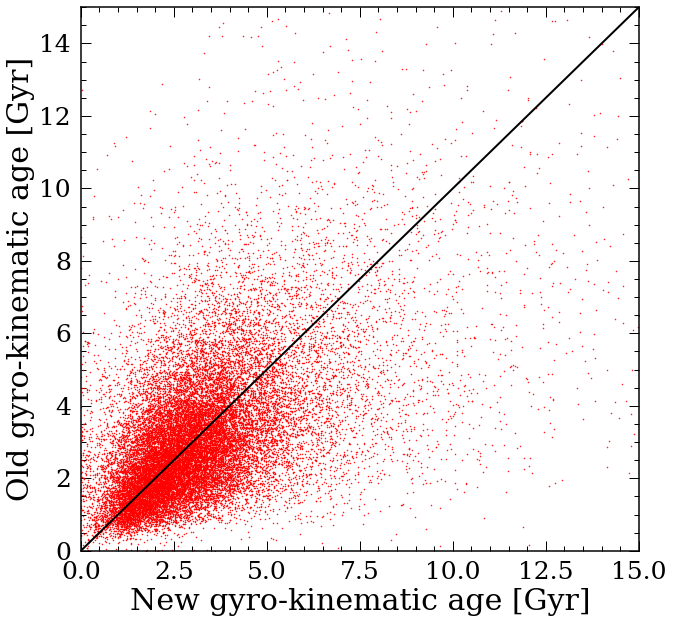

In [25]:
cm_df = pd.merge(df_nob, oldage, left_on='KID', right_on='KID', how='inner')
plt.plot(cm_df['kin_age_x'], cm_df['kin_age_y'], 'r.', markersize=1)
plt.plot([0,15], [0,15], 'k-')
plt.xlim([0,15])
plt.ylim([0,15])
plt.xlabel('New gyro-kinematic age [Gyr]')
plt.ylabel('Old gyro-kinematic age [Gyr]')

# Compare to other ages

In [26]:
def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G',
             agename = 'kin_age'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in trange(len(f1_star)):
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['kin_age'].iloc[0]
        count=count+1
    return KIDs

### cluster

In [27]:
age_cluster = findstars(df_nob, clusters['Teff'].values, clusters['Prot'].values, clusters['MGmag'].values,
                    f1='teff_calc',f2='Prot',f3='abs_G', agename='kin_age_ave')


100%|██████████| 923/923 [00:08<00:00, 108.66it/s]


In [28]:
real_cluster_age = clusters['Age'].unique()
ave_cluster_age = np.zeros(len(real_cluster_age))
ave_cluster_age_err = np.zeros(len(real_cluster_age))
for i in range(len(real_cluster_age)):
    m = clusters['Age']==real_cluster_age[i]
    ave_cluster_age[i] = np.median(pd.Series(age_cluster[m]).dropna())
    ave_cluster_age_err[i] = np.std(pd.Series(age_cluster[m]).dropna())
    
real_cluster_age = np.array([float(i) for i in real_cluster_age])


### isochrone

In [29]:
getAveAges(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                opt_binsize,vz='all_vz')


100%|██████████| 27714/27714 [1:04:09<00:00,  7.20it/s]
<ipython-input-1-810b26a1c2c9>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


ValueError: too many values to unpack (expected 2)

In [34]:

iso_kin = df_nob.loc[df_nob['Ro']<2]


Text(0, 0.5, 'Gyro-kinematic Age [Gyr]')

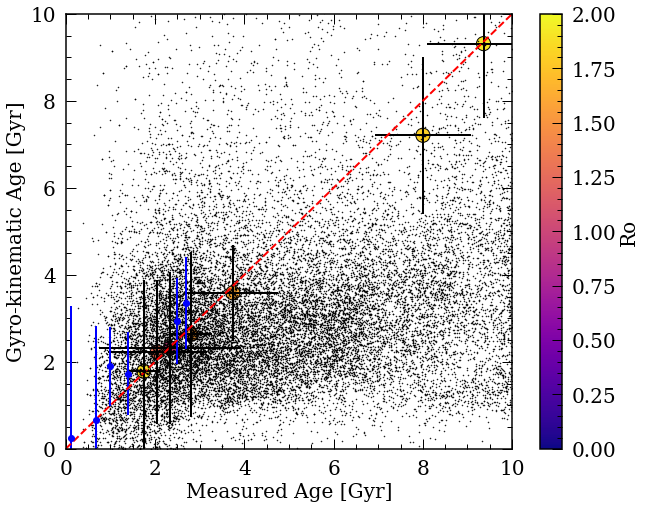

In [47]:
pltave = 'kin_age'

df_common = df_common.loc[df_common['KID']>1000].reset_index(drop=True)
df_AS = pd.merge(df_common[['KID','measure_age','measure_age_err']], 
                 df_nob, left_on='KID', right_on='KID',how='inner')

plt.figure(figsize=(10,8))
plt.plot(df_nob['iso_age_ave'], df_nob[pltave],'k.', markersize=1)

plt.errorbar(df_AS['measure_age'],df_AS[pltave],
             xerr=df_AS['measure_age_err'],yerr=df_AS['kin_age_err'],
             fmt='k.')

plt.scatter(df_AS['measure_age'],df_AS[pltave],
             c=df_AS['Ro'],s=200,edgecolor='k',vmin=0,vmax=2,
           cmap='plasma')

plt.errorbar(real_cluster_age,ave_cluster_age,
              yerr=ave_cluster_age_err,fmt='bo')


cb = plt.colorbar()
cb.set_label('Ro')
plt.plot([0,10],[0,10],'r--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')




### XD

In [31]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.


/opt/homebrew/anaconda3/lib/python3.8/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [51]:

df_prot_s=iso_kin.loc[iso_kin['iso_age']<10]
df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]
df_prot_s=df_prot_s.dropna(subset=['iso_age_ave','iso_age_err1','kin_age','kin_age_err','kin_age_ave'])

iso = df_prot_s.iso_age_ave.values
kin = df_prot_s[pltave].values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_prot_s.iso_age_err1.values ** 2, df_prot_s.kin_age_err.values ** 2]).T

#------------------------------------------------------------
# compute and save results
@pickle_results("XD.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(200)





@pickle_results: using precomputed results from 'XD.pkl'


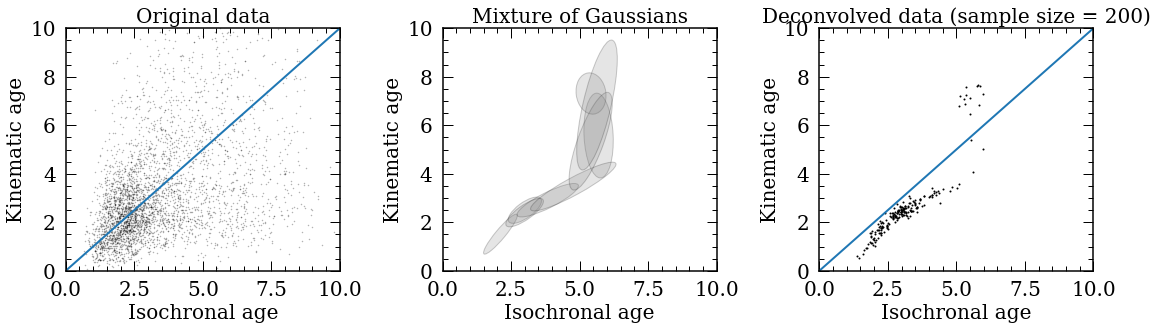

In [52]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);

plt.tight_layout()


Text(0, 0.5, 'Gyro-kinematic Age [Gyr]')

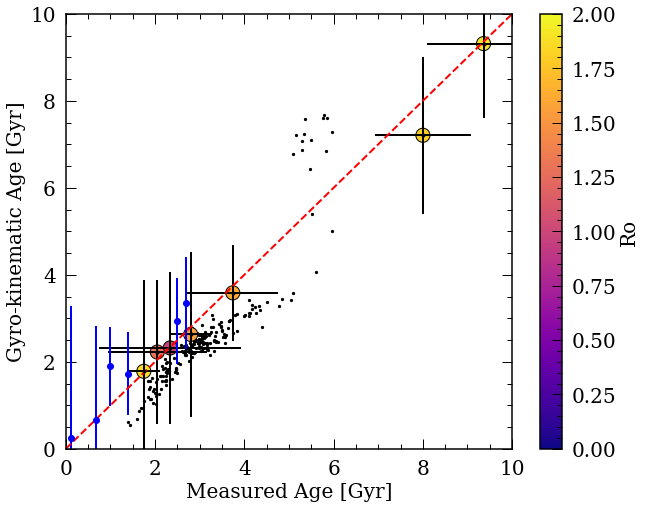

In [53]:
pltave = 'kin_age'


df_common = df_common.loc[df_common['KID']>1000].reset_index(drop=True)
df_AS = pd.merge(df_common[['KID','measure_age','measure_age_err']], 
                 df_nob, left_on='KID', right_on='KID',how='inner')

plt.figure(figsize=(10,8))

plt.scatter(sample[:, 0], sample[:, 1],s=5, c='k')
plt.errorbar(df_AS['measure_age'],df_AS[pltave],
             xerr=df_AS['measure_age_err'],yerr=df_AS['kin_age_err'],
             fmt='k.')

plt.scatter(df_AS['measure_age'],df_AS[pltave],
             c=df_AS['Ro'],s=200,edgecolor='k',vmin=0,vmax=2,
           cmap='plasma')

plt.errorbar(real_cluster_age,ave_cluster_age,
              yerr=ave_cluster_age_err,fmt='bo')


cb = plt.colorbar()
cb.set_label('Ro')
plt.plot([0,10],[0,10],'r--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')





In [55]:
#df_nob.to_pickle('NewKinAge.pkl')

Text(0, 0.5, 'Ro')

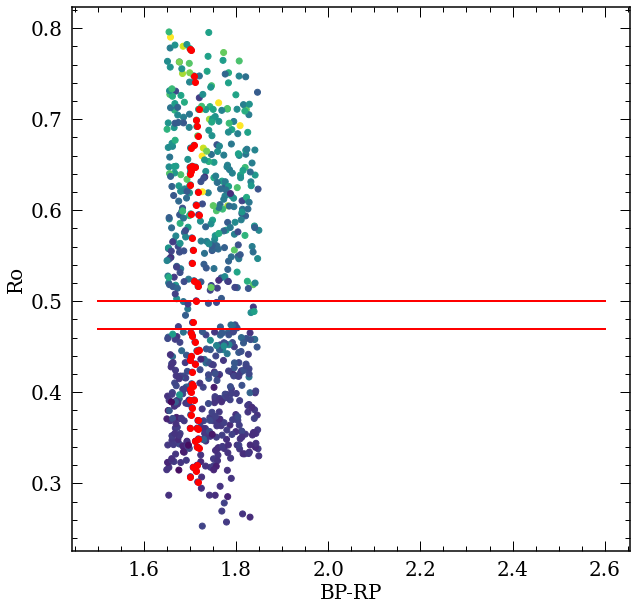

In [436]:
clim = [1.7,1.72]
gap = [0.47,0.5]
#mincut = 1.65
#maxcut = 1.85
mincut = 1.65
maxcut = 1.85


df_nob_gap = df_nob.loc[df_nob['Prot']>10]
df_nob_gap = df_nob_gap.loc[df_nob_gap['Prot']<30]
df_nob_gap = df_nob_gap.loc[df_nob_gap['bp_rp']>mincut]
df_nob_gap = df_nob_gap.loc[df_nob_gap['bp_rp']<maxcut]





plt.scatter(df_nob_gap['bp_rp'],df_nob_gap['Ro'],c=df_nob_gap['kin_age'],vmin=0,
           vmax=10)
df_nob_gap_ss = df_nob_gap.loc[(df_nob_gap['bp_rp']>clim[0])&(df_nob_gap['bp_rp']<clim[1])]
plt.scatter(df_nob_gap_ss['bp_rp'],df_nob_gap_ss['Ro'],c='r')
plt.plot([1.5,2.6], [gap[0],gap[0]], 'r-')
plt.plot([1.5,2.6], [gap[1],gap[1]], 'r-')
plt.xlabel('BP-RP')
plt.ylabel('Ro')


In [440]:
def f(x, a):
    return 0.5*x+a


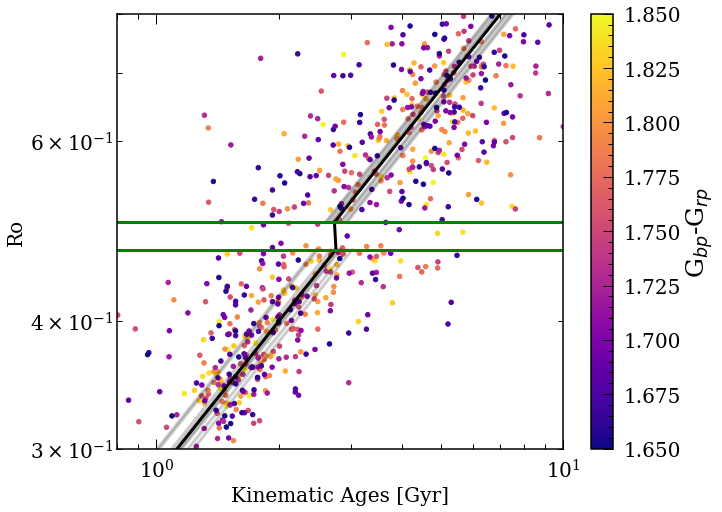

In [451]:

clim = np.linspace(mincut, maxcut, 10)
colors = getcolor(clim)
alla1s = np.zeros(len(clim)-1)
alla2s = np.zeros(len(clim)-1)
alla1s_err = np.zeros(len(clim)-1)
alla2s_err = np.zeros(len(clim)-1)

plt.figure(figsize=(10,8))

plt.scatter(df_nob_gap['kin_age'],df_nob_gap['Ro'], 
            c=df_nob_gap['bp_rp'], s=20,cmap='plasma',vmin=mincut, 
            vmax=maxcut)

for i in range(len(clim)-1):
    df_nob_gap_ss = df_nob_gap.loc[(df_nob_gap['bp_rp']>clim[i])&(df_nob_gap['bp_rp']<clim[i+1])]


    df_nob_gap_ss_all = df_nob_gap_ss.sort_values(by='kin_age').reset_index(drop=True)

    
    smoothprot = gaussian_filter(df_nob_gap_ss['Ro'], 3)


    #"""------------------------- fit lines -------------------------"""
    from scipy.optimize import curve_fit
    m = df_nob_gap_ss['Ro']<gap[0]
    m2 = df_nob_gap_ss['Ro']>gap[1]

    popt, pcov = curve_fit(f, np.log(df_nob_gap_ss['kin_age'][m]), 
                           np.log(df_nob_gap_ss['Ro'][m]))
    x = np.linspace(0,np.exp((np.log(gap[0])-popt[0])/0.5),50)
    plt.plot(x, x**0.5*np.exp(popt[0]), 'k-', linewidth=3, 
            label='%.2f < BP-RP < %.2f'%(clim[i],clim[i+1]), alpha=0.2)
    alla1s[i] = popt[0]
    alla1s_err[i] = np.sqrt(np.diag(pcov))[0]

    popt, pcov = curve_fit(f, np.log(df_nob_gap_ss['kin_age'][m2]), 
                           np.log(df_nob_gap_ss['Ro'][m2]))
    x = np.linspace(np.exp((np.log(gap[1])-popt[0])/0.5),20,50)
    plt.plot(x, x**0.5*np.exp(popt[0]), 'k-', linewidth=3, alpha=0.2)
    alla2s[i] = popt[0]
    alla2s_err[i] = np.sqrt(np.diag(pcov))[0]

    #"""------------------------- fit lines -------------------------"""

#plt.legend()

x = np.linspace(0, np.exp((np.log(gap[0])-np.median(alla1s))/0.5),50)
plt.plot(x, x**0.5*np.exp(np.median(alla1s)), 'k-', linewidth=3)

x = np.linspace(np.exp((np.log(gap[1])-np.median(alla2s))/0.5),20,50)
plt.plot(x, x**0.5*np.exp(np.median(alla2s)), 'k-', linewidth=3)
    
plt.plot([np.exp((np.log(gap[0])-np.median(alla1s))/0.5), 
         np.exp((np.log(gap[1])-np.median(alla2s))/0.5)],
        gap, 'k-', linewidth=3)
    
plt.xlim([0.8,10])
plt.ylim([0.3,0.8])
plt.xlabel('Kinematic Ages [Gyr]')
plt.ylabel('Ro')

plt.plot([0, 10], [gap[0], gap[0]], 'g-', linewidth=3, label='gap')
plt.plot([0, 10], [gap[1], gap[1]], 'g-', linewidth=3)

plt.yscale('log')
plt.xscale('log')

"""plt.twinx()
plt.hist(df_nob_gap['kin_age'].values, color='k',
         bins=10**np.linspace(-1,1,50), alpha=0.1)
plt.ylabel('Frequency',fontsize=25)"""
cb = plt.colorbar()
cb.set_label('G$_{bp}$-G$_{rp}$', fontsize=25)

plt.savefig('../ZTF/Figures/GyroAge.png', bbox_inches='tight')

In [455]:
alla1s_err/abs(alla1s)

array([0.0294506 , 0.0232716 , 0.02835703, 0.02006227, 0.0214079 ,
       0.0177358 , 0.01725456, 0.0124703 , 0.01980935])

In [457]:
alla2s_err/abs(alla2s)

array([0.02186347, 0.02342491, 0.02032433, 0.04001161, 0.02075627,
       0.02596552, 0.02520504, 0.02491954, 0.0343096 ])

/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-336-e6bc63697d78>:52: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(pad=0.15)
<ipython-input-336-e6bc63697d78>:55: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.tight_layout()
<ipython-input-336-e6bc63697d78>:56: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('../ZTF/Figures/GyroAge.png', bbox_inches='tight')
/opt/homebrew/anaconda3/lib/python3.8/site-

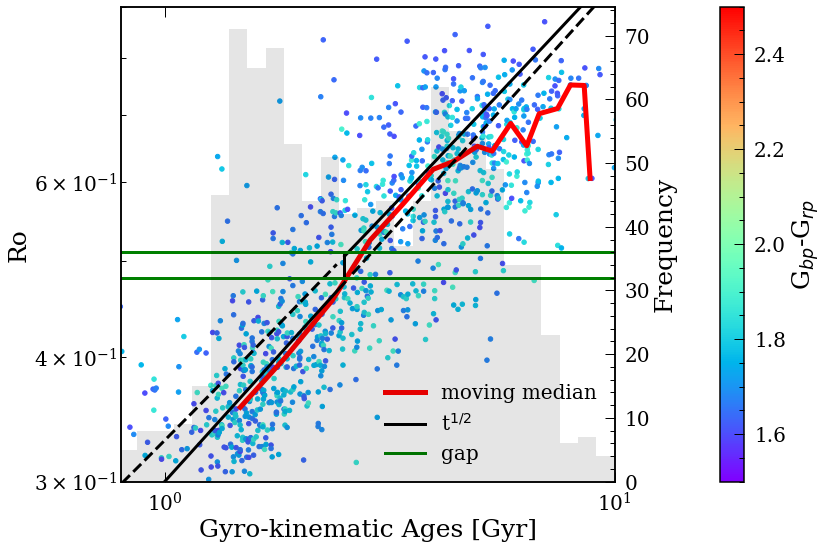

In [336]:
x = np.linspace(0,20,200)
df_nob_gap = df_nob_gap.sort_values(by='kin_age').reset_index(drop=True)

plt.figure(figsize=(12,8))
plt.scatter(df_nob_gap['kin_age'],df_nob_gap['Ro'], 
            c=df_nob_gap['bp_rp'], s=20,cmap='rainbow',vmin=1.5, 
            vmax=2.5)
"""smoothage, smoothprot = movingMed_time(np.log(df_nob_gap['kin_age'].values), 
                            np.log(df_nob_gap['Ro'].values), 0.05, 0.15)
smoothage, smoothprot = np.exp(smoothage), np.exp(smoothprot)"""

smoothage, smoothprot = movingMed_time(df_nob_gap['kin_age'].values, 
                            df_nob_gap['Ro'].values, 0.1, 0.5)

m = (smoothage>1)&(smoothage<9)
smoothage, smoothprot = smoothage[m], smoothprot[m]


plt.plot(smoothage, smoothprot, 'r-', linewidth=5, 
         label='moving median')

m2 = x<2.6
plt.plot(x[m2], x[m2]**0.5*0.3, 'k-', linewidth=3, 
         label='t$^{1/2}$')
plt.plot(x[~m2], x[~m2]**0.5*0.3, 'k--', linewidth=3)

m3 = x>2.5
plt.plot(x[m3], x[m3]**0.5*0.3+0.03, 'k-', linewidth=3)
plt.plot(x[~m3], x[~m3]**0.5*0.3+0.03, 'k--', linewidth=3)

plt.plot([2.5,2.5], [0.48,0.51], 
         'k-', linewidth=3)

plt.xlim([0.8,10])
plt.ylim([0.3,0.9])
plt.xlabel('Gyro-kinematic Ages [Gyr]', fontsize=25)
plt.ylabel('Ro', fontsize=25)

plt.plot([0, 10], [0.48,0.48], 'g-', linewidth=3, label='gap')
plt.plot([0, 10], [0.51,0.51], 'g-', linewidth=3)


plt.legend(fontsize=20)

plt.yscale('log')
plt.xscale('log')

plt.twinx()
plt.hist(df_nob_gap['kin_age'].values, color='k',
         bins=10**np.linspace(-1,1,50), alpha=0.1)
plt.ylabel('Frequency',fontsize=25)
cb = plt.colorbar(pad=0.15)
cb.set_label('G$_{bp}$-G$_{rp}$', fontsize=25)

plt.tight_layout()
plt.savefig('../ZTF/Figures/GyroAge.png', bbox_inches='tight')

In [313]:
np.logspace(1,10,10)

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10])